# Step 3: Cluster Distribution Statistical Analysis
Calculate statstical information on cluster distributions isolated in the 'Step 2' Cluster Network Isolation notebook. 

---
Here, we can compute information such as:

- Coordination Number Distributions
- Bond Length, Angle Distributions
- Volume Distributions
- Cluster Atom Count Distributions
- Volume Fraction (Scattering) Contributions

## Custom Imports
Relative import the custom classes to support the cluster network tool.

In [1]:
# Import and run the setup script
import sys, os
import numpy as np

# Ensure the project root is in sys.path to locate setup_env
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import the setup helper and configure the environment
from setup_env import setup_environment

# Capture the imported classes from setup_environment
RadiusOfGyrationCalculator, PDBEditor, TrajectoryProcessor, PDBFileHandler, Atom, ClusterNetwork, ClusterBatchAnalyzer = setup_environment()

Scripts directory '/Users/keithwhite/repos/MDScatter/scripts' has been added to sys.path.
Class imports have been set up.


## Cluster Single Frame Analysis

### Bond Length and Angle Distributions

In [ ]:
# Define the path to the PDB file and initialize the handler
pdb_file_path = '/Users/keithwhite/repos/MDScatter/data/example/frame_0001.pdb'
core_residue_names = ['PBI']
shell_residue_names = ['DMS']
pdb_handler = PDBFileHandler(pdb_file_path, core_residue_names, shell_residue_names)

# Initialize ClusterNetwork with relevant parameters
node_elements = ['Pb']
linker_elements = ['Pb', 'I']
terminator_elements = ['I']
segment_cutoff = 3.7
cluster_network = ClusterNetwork(
    pdb_handler.core_atoms,
    pdb_handler.shell_atoms,
    node_elements,
    linker_elements,
    terminator_elements,
    segment_cutoff,
    core_residue_names,
    shell_residue_names
)

# Analyze networks
networks = cluster_network.analyze_networks()

# Specify bond lengths and angles to calculate
# bond_length_pairs = [('Pb', 'I', 3.8), ('I', 'I', 7.6)]
bond_length_pairs = [('Pb', 'I', 3.8)] #, ('I', 'I', 7.6)]
bond_angle_triplets = [('I', 'Pb', 'I', 3.8)]

# Calculate and plot distributions
cluster_network.calculate_and_plot_distributions(bond_length_pairs, bond_angle_triplets)

### Coordination Number Distributions

In [ ]:
# Calculate coordination numbers
target_elements = ['Pb']
neighbor_elements = ['I', 'O']
distance_thresholds = {('Pb', 'I'): 3.8, ('Pb', 'O'): 3}
coordination_stats, total_stats = cluster_network.calculate_coordination_numbers(target_elements, neighbor_elements, distance_thresholds)

# Print coordination numbers
cluster_network.print_coordination_numbers(coordination_stats, total_stats)

### Coordination Number Heatmap

In [ ]:
# Define parameters for the heatmap
central_element = 'Pb'
x_pair = ('Pb', 'I')
y_pair = ('Pb', 'O')
x_range = (0, 6)  # Range for Pb-I coordination number
y_range = (0, 6)  # Range for Pb-O coordination number
distance_cutoffs = {('Pb', 'I'): 3.5, ('Pb', 'O'): 3}

# Calculate and plot the heatmap
cluster_network.calculate_and_plot_heatmap(central_element, x_pair, y_pair, x_range, y_range, distance_cutoffs)


## Cluster Batch Frame Analysis

### Setup
Checking coordination numbers and elements in Mendeleev data repository to help with input fields for cluster analyzer.

In [ ]:
from mendeleev import element

# Retrieve the element information for oxygen
oxygen = element('I')

# Fetch the ionic radii for oxygen in different oxidation states
ionic_radii = oxygen.ionic_radii

# Print the ionic radii for each oxidation state
for ir in ionic_radii:
    print(f"Oxidation State: {ir.charge}, Coordination: {ir.coordination}, Ionic Radius: {ir.ionic_radius} pm")


### Setup the Cluster Batch Analyzer

In [2]:
%matplotlib widget

## -- DEFINE THE PDB FOLDER PATH
# pdb_directory = '/Users/keithwhite/repos/MDScatter/data/example/solute_cluster_pdb_files_240920_164337'
pdb_directory = '/Users/keithwhite/repos/MDScatter/data/example/solute-solvent_cluster_pdb_files'

## -- SETUP FOR FIRST COORDINATION SHELL
target_elements = ['Pb']
neighbor_elements = ['O', 'I']
distance_thresholds = {
    ('Pb', 'O'): 3.0,  # Example threshold distances in angstroms
    ('Pb', 'I'): 3.6
}

## -- FOR CHARGE DISTRIBUTION CALCULATION - USE SETUP TOOL TO SET THESE VALUES
partial_charges = {
    'Pb': (2, 6),    # Lead with a charge of 2+ and coordination number of 6
    'I': (-1, 6),    # Iodine with a charge of 1- and coordination number of 6
    'S': (-2, 6),    # Sulfur in DMSO with a neutral charge and coordination number of 2
    'O': (-2, 2),    # Oxygen in DMSO with a charge of 2- and coordination number of 2
    'C': (4, 4),     # Carbon in DMSO with a neutral charge and coordination number of 4
    'H': (1, 1)      # Hydrogen in DMSO with a neutral charge and coordination number of 1
}

# Instantiate the ClusterBatchAnalyzer class with the necessary parameters
analyzer = ClusterBatchAnalyzer(
    pdb_directory=pdb_directory,
    target_elements=target_elements,
    neighbor_elements=neighbor_elements,
    distance_thresholds=distance_thresholds,
    charges=partial_charges,
    core_residue_names=['PBI'], 
    shell_residue_names=['DMS'],
    volume_method='radius_of_gyration'  # Choose the radius of gyration method
)

### Statistical Analysis of Clusters

In [ ]:
## -- Analyze clusters to compute coordination numbers and volumes
# Specify shape_type='sphere' to use spherical approximation with radius of gyration

coordination_stats_per_size = analyzer.analyze_clusters(shape_type='sphere')
# coordination_stats_per_size = analyzer.analyze_clusters(shape_type='ellipsoid')

## Sorted Cluster Analysis

### Sort Clusters into Folders by Node Element Count

In [ ]:
analyzer.sort_pdb_files_by_node_count(node_elements=['Pb'])

In [3]:
# User provides the path to the sorted folder
sorted_pdb_folder = '/Users/keithwhite/repos/MDScatter/data/example/sorted_solute-solvent_cluster_pdb_files'

# Define the target and neighbor elements
target_elements = ['Pb']  # Example target elements
neighbor_elements = ['O', 'I']  # Example neighbor elements

# Define distance thresholds for atom pairs
distance_thresholds = {
    ('Pb', 'O'): 3.0,  # Threshold distances in angstroms
    ('Pb', 'I'): 3.8
}

# Run the coordination calculation with distance thresholds
coordination_stats, sharing_patterns = analyzer.calculate_coordination_stats_by_subfolder(
    sorted_pdb_folder=sorted_pdb_folder,
    target_elements=target_elements,
    neighbor_elements=neighbor_elements,
    distance_thresholds=distance_thresholds
)

# Print coordination statistics per subfolder
for subfolder, stats in coordination_stats.items():
    print(f"\nSubfolder: {subfolder}")
    for pair, counts in stats.items():
        mean = np.mean(counts)
        std = np.std(counts)
        print(f"  {pair[0]} coordinated by {pair[1]}: Mean = {mean:.2f}, Std Dev = {std:.2f}")

# Generate tables per folder
for subfolder, multiplicity_counts in analyzer.per_folder_multiplicity_counts.items():
    analyzer.generate_ascii_table(multiplicity_counts, title=f"Multiplicity Counts for Folder: {subfolder}")

# Generate overall table
analyzer.generate_ascii_table(analyzer.overall_multiplicity_counts, title="Overall Multiplicity Counts Across All Folders")

# Report the sharing patterns
print("\nSharing Patterns:")
for pattern, count in sharing_patterns.items():
    num_targets, target_element, num_neighbors, neighbor_element = pattern
    print(f"{count} instance(s) of {num_targets} {target_element} atom(s) sharing {num_neighbors} {neighbor_element} atom(s)")

Processing subfolders:   0%|                                                  | 0/8 [00:00<?, ?it/s]


Subfolder: node_Pb_ac001
  Pb coordinated by O: Mean = 4.91, Std Dev = 1.81
  Pb coordinated by I: Mean = 0.95, Std Dev = 0.71

Subfolder: node_no_element_ac000

Subfolder: node_Pb_ac002
  Pb coordinated by O: Mean = 2.00, Std Dev = 0.00
  Pb coordinated by I: Mean = 3.50, Std Dev = 0.50

Subfolder: node_Pb_ac004
  Pb coordinated by O: Mean = 2.75, Std Dev = 2.28
  Pb coordinated by I: Mean = 2.50, Std Dev = 1.12

Subfolder: node_Pb_ac003
  Pb coordinated by O: Mean = 2.17, Std Dev = 0.69
  Pb coordinated by I: Mean = 3.17, Std Dev = 0.37

Subfolder: node_Pb_ac016
  Pb coordinated by O: Mean = 1.38, Std Dev = 1.36
  Pb coordinated by I: Mean = 3.50, Std Dev = 0.94

Subfolder: node_Pb_ac011
  Pb coordinated by O: Mean = 0.73, Std Dev = 0.96
  Pb coordinated by I: Mean = 3.64, Std Dev = 1.49

Multiplicity Counts for Folder: node_Pb_ac001
     1
I   21
O  108

Multiplicity Counts for Folder: node_Pb_ac002
   1  2
I  3  2
O  4  0

Multiplicity Counts for Folder: node_Pb_ac004
    1  2
I  

### Plotting 'Sorted' Cluster Analysis
- Plot average coordination number by cluster size and neighbor element.
- Plot coordination environment heatmap.
- Plot distribution of unique coordination environments, including motifs.


/Users/keithwhite/repos/MDScatter/scripts/cluster/clusterbatchanalyzer.py:1438: FutureWarning: The provided callable <function sum at 0x1172e85e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pivot_df = df.pivot_table(


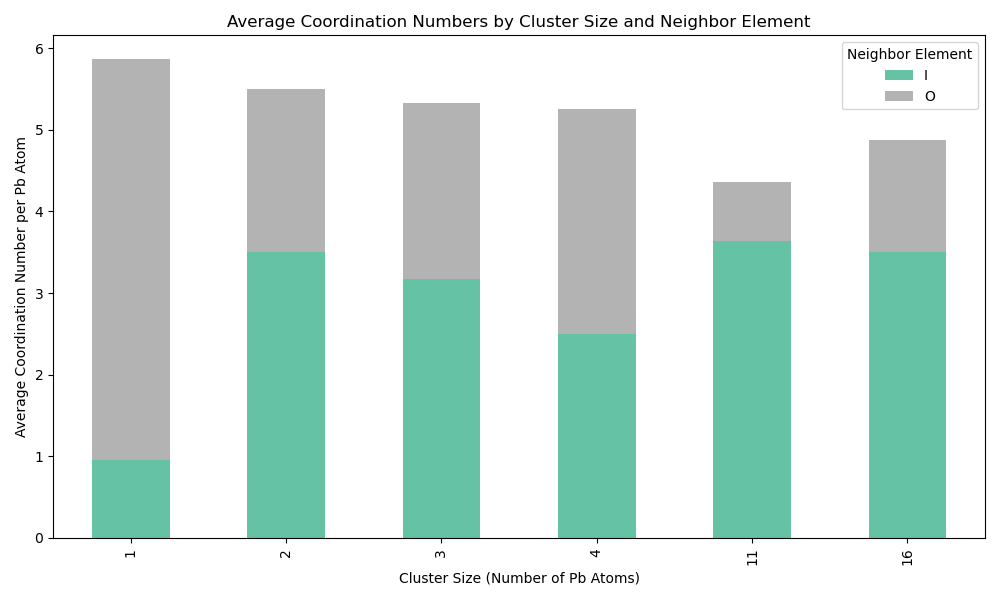

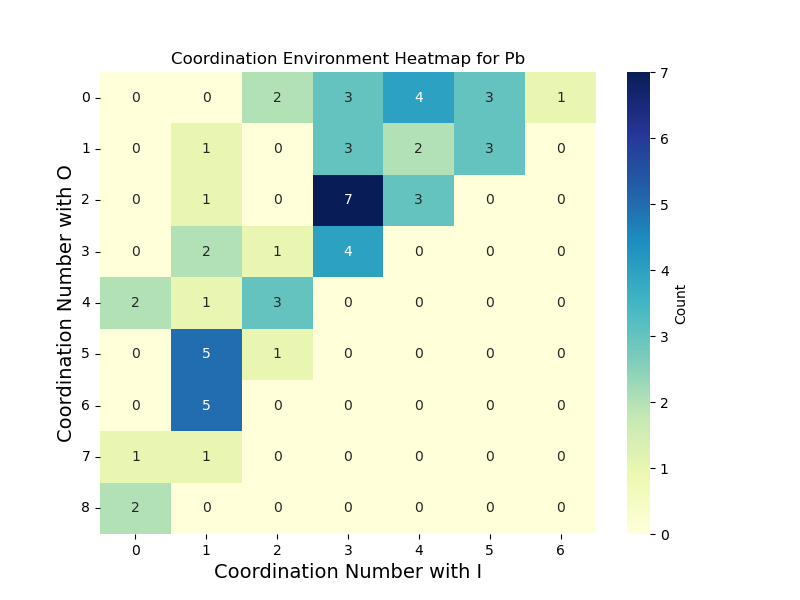

In [5]:

# Plot average coordination numbers
analyzer.plot_average_coordination_numbers()

# # Plot coordination number distribution
# analyzer.plot_coordination_number_distribution()

# Define the central element and neighbor elements
central_element = 'Pb'
neighbor_elements = ['I', 'O']  # Exactly two neighbor elements

# Define the ranges for coordination numbers
x_range = (0, 6)  # For 'I' coordination numbers ranging from 0 to 8
y_range = (0, 8)  # For 'O' coordination numbers ranging from 0 to 8

# Call the method to calculate and plot the heatmap
analyzer.calculate_and_plot_coordination_heatmap_from_data(
    central_element=central_element,
    neighbor_elements=neighbor_elements,
    x_range=x_range,
    y_range=y_range
)

##### Unique Coordination Environments

Processing subfolders:   0%|                                                  | 0/8 [00:00<?, ?it/s]

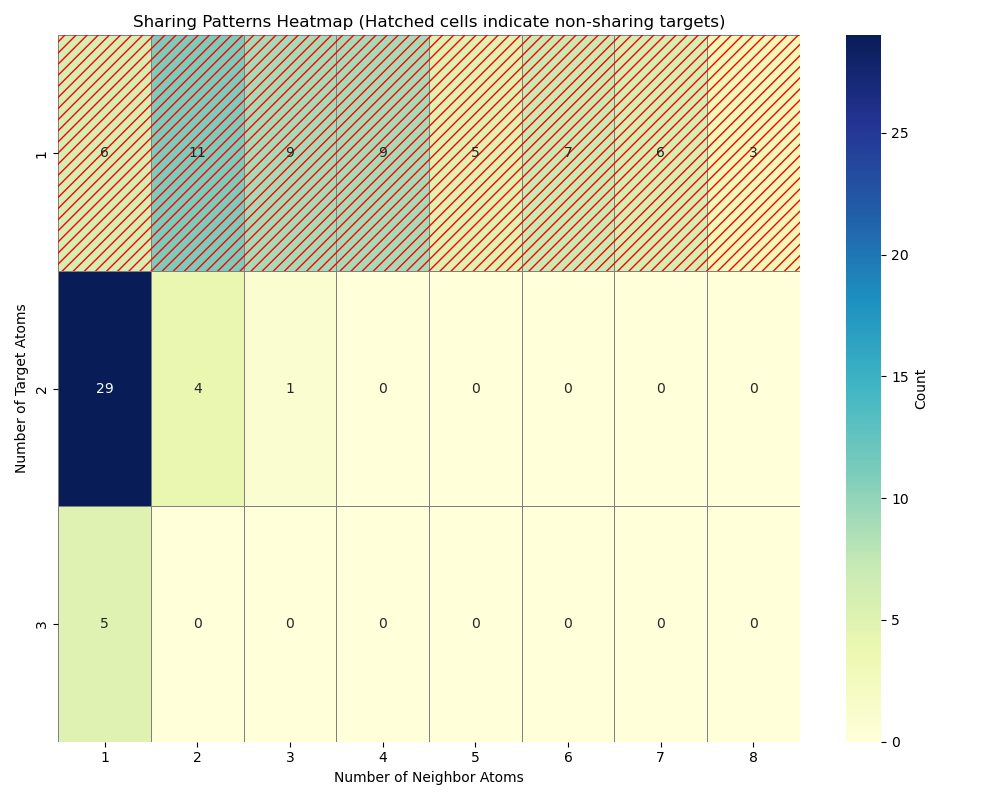

In [4]:
# After running calculate_coordination_stats_by_subfolder
coordination_stats, sharing_patterns = analyzer.calculate_coordination_stats_by_subfolder(
    sorted_pdb_folder=sorted_pdb_folder,
    target_elements=target_elements,
    neighbor_elements=neighbor_elements,
    distance_thresholds=distance_thresholds
)

# Plot the sharing patterns heatmap
analyzer.plot_sharing_patterns_heatmap(sharing_patterns)


##### Coordination Number Distributions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


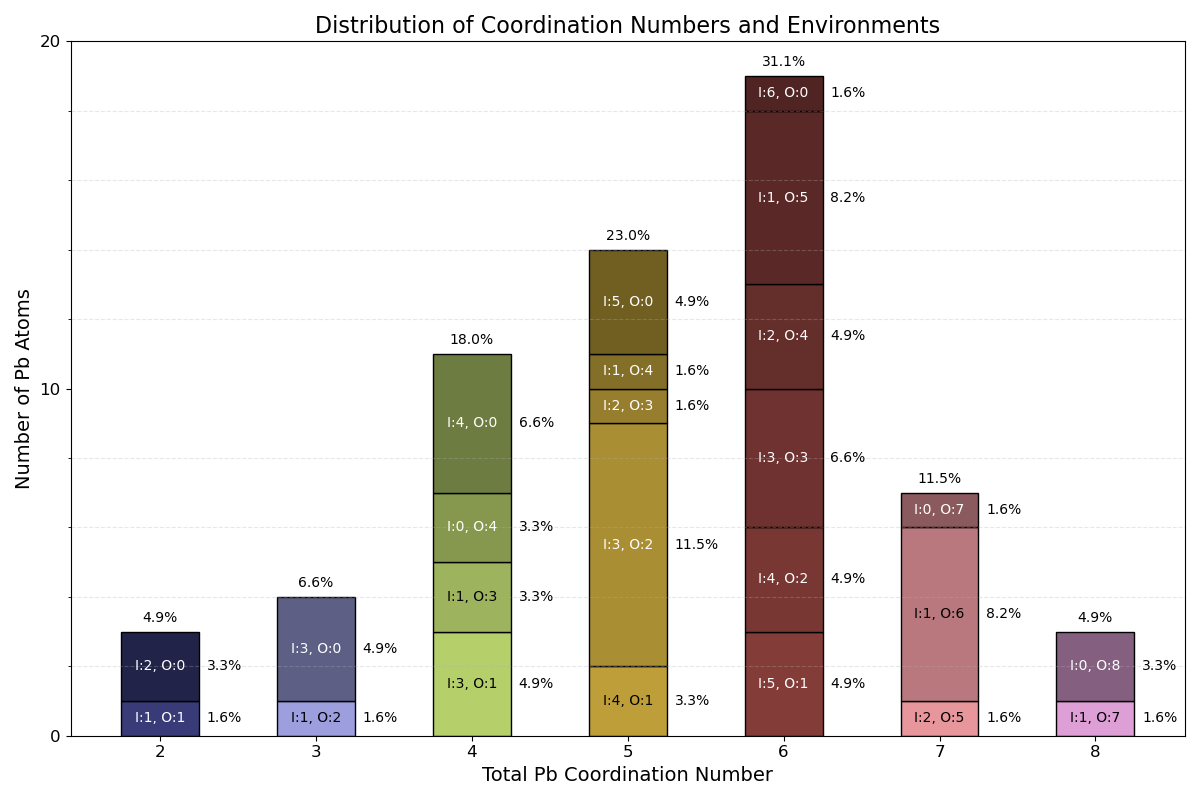

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


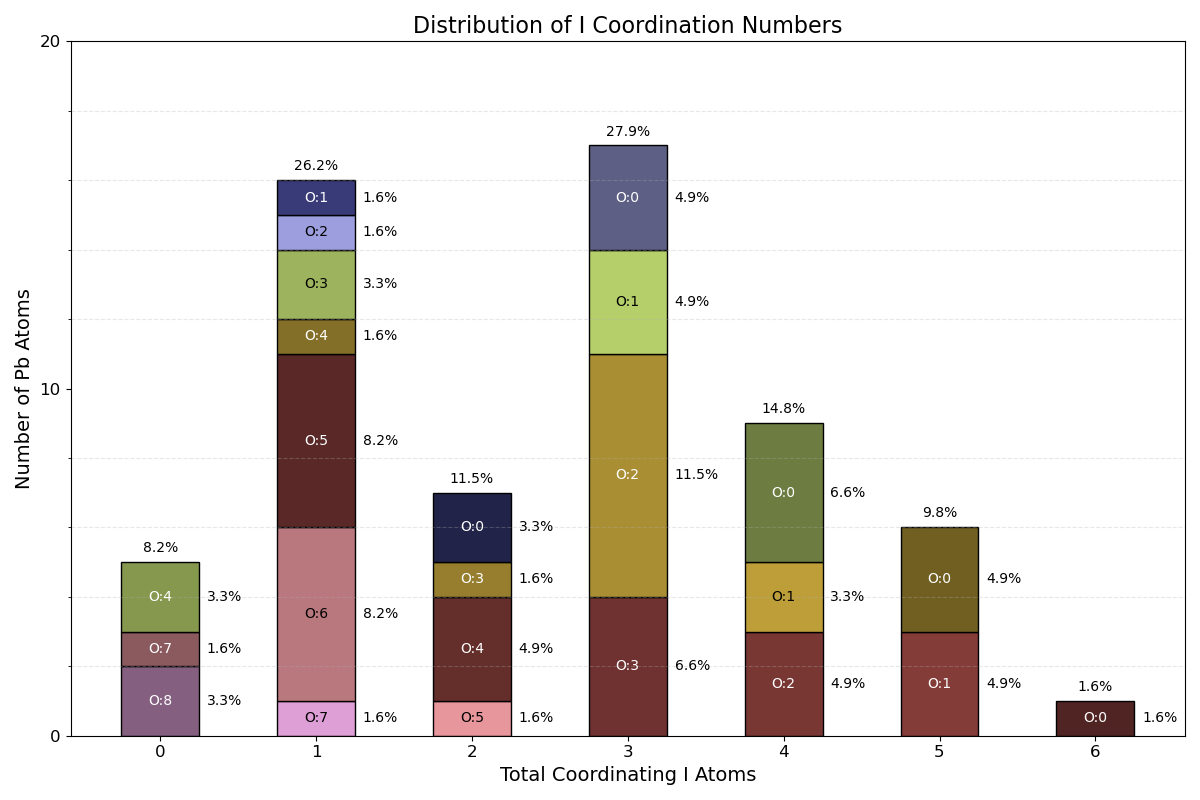

In [6]:
# Prepare the coordination distribution data
analyzer.prepare_coordination_distribution_data()

# Use Case 1: Plot Coordination Number Distribution
analyzer.plot_coordination_number_distribution()

# # Use Case 2: Plot Neighbor Atom Distribution for 'I'
analyzer.plot_neighbor_atom_distribution(neighbor_atom='I')